In [1]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Input, Embedding, LSTM, Dense, merge, Convolution2D, MaxPooling2D, Reshape, Flatten, Dropout
from keras.optimizers import RMSprop, Adam
from keras import initializations

Using TensorFlow backend.


In [2]:
# Util functions
def my_init(shape, name=None):
    return initializations.normal(shape, scale=0.01, name=name)

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [3]:
# TODO: Fill this in based on where you saved the training and testing data

training_file = '/home/autti/Downloads/traffic-signs-data/train_p2.p'
testing_file = '/home/autti/Downloads/traffic-signs-data/test_p2.p'


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)


X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

('shape train', (39209, 32, 32, 3))
[[ 75  74  83 ...,  67  65  66]
 [ 82  80  87 ...,  73  75  79]
 [ 79  84  91 ...,  72  74  78]
 ..., 
 [126 118 108 ...,  96  99  99]
 [ 90  91  77 ..., 104 107  95]
 [ 85  93  69 ..., 101  98  90]]
('labels', (39209,))


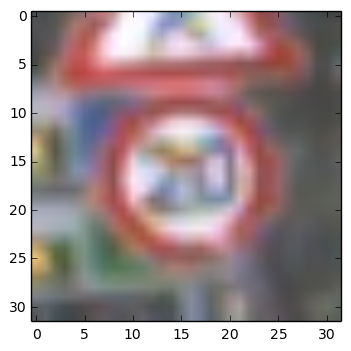

In [4]:
print("shape train", X_train.shape)
print(X_train[0, :, :, 0])
print("labels", y_train.shape)
plt.figure()
plt.imshow(X_train[0, :, :, :])

In [5]:
# normalize data
X_train = X_train.astype(np.float32)/255
X_train -= 0.5
print(X_train[0,:,:,0])
print("max",np.max(y_train),"min",np.min(y_train))
y_label = np.zeros(shape=(y_train.shape[0], np.max(y_train) + 1))

for i in range(y_train.shape[0]):
    y_label[i, y_train[i]]=1

#X_train = X_train[:10]
#y_label = y_label[:10]
#print(y_label[-2:,:])

[[-0.20588234 -0.20980391 -0.17450979 ..., -0.23725489 -0.24509802
  -0.24117646]
 [-0.17843136 -0.1862745  -0.15882352 ..., -0.21372548 -0.20588234
  -0.19019607]
 [-0.19019607 -0.17058823 -0.14313725 ..., -0.21764705 -0.20980391
  -0.19411764]
 ..., 
 [-0.00588235 -0.0372549  -0.07647058 ..., -0.1235294  -0.1117647
  -0.1117647 ]
 [-0.14705881 -0.14313725 -0.1980392  ..., -0.09215686 -0.08039215
  -0.12745097]
 [-0.16666666 -0.13529411 -0.22941175 ..., -0.10392156 -0.11568627
  -0.14705881]]
('max', 42, 'min', 0)


In [6]:
prefix = 'traffic'
model_path ='.model_{0}.h5'.format(prefix) 
sgd_select = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [7]:
# network architecture

# input layer
main_input = Input(shape=(32, 32, 3), name='main_input')

color_map = Convolution2D(3, 1, 1, init=my_init, border_mode='same')(main_input)

conv1 = Convolution2D(32, 3, 3, init=my_init, border_mode='same')(color_map)
conv2 = Convolution2D(32, 3, 3, init=my_init, border_mode='same')(conv1)
pool1 = MaxPooling2D(pool_size=(3, 3))(conv2)
drop1 = Dropout(0.5)(pool1)

conv3 = Convolution2D(64, 3, 3, init=my_init, border_mode='same')(drop1)
conv4 = Convolution2D(64, 3, 3, init=my_init, border_mode='same')(conv3)
pool2 = MaxPooling2D(pool_size=(3, 3))(conv4)
drop2 = Dropout(0.5)(pool2)

conv5 = Convolution2D(128, 3, 3, init=my_init, border_mode='same')(drop2)
conv6 = Convolution2D(128, 3, 3, init=my_init, border_mode='same')(conv5)
pool3 = MaxPooling2D(pool_size=(3, 3))(conv6)
drop3 = Dropout(0.5)(pool3)

# flatten layer
flat1 = Flatten()(drop1)
flat2 = Flatten()(drop2)
flat3 = Flatten()(drop3)

# concatenate all vectors
merged1 = merge([flat1, flat2, flat3], name='merge1', mode='concat',concat_axis = 1)

fc1 = Dense(1024)(merged1)
drop4 = Dropout(0.5)(fc1)

fc2 = Dense(1024)(drop4)
drop5 = Dropout(0.5)(fc2)

softmax_layer = Dense(43)(drop5)
main_output = Activation('softmax')(softmax_layer)
print("final", main_output)

('final', <tf.Tensor 'Softmax:0' shape=(?, 43) dtype=float32>)


In [8]:
from keras.preprocessing.image import NumpyArrayIterator
from keras.preprocessing.image import transform_matrix_offset_center
from keras.preprocessing.image import apply_transform

def augment_brightness_camera_images(image):
    """
    From: https://github.com/vxy10/ImageAugmentation
    """
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1


def transform_image(img, ang_range, shear_range, trans_range, brightness=False):
    '''
    From: https://github.com/vxy10/ImageAugmentation
    
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    
    # Brightness 
    

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    
    if brightness:
        img = augment_brightness_camera_images(img)
    
    return img


class LavoeImageDataGenerator(object):
    """Generate minibatches with
    real-time data augmentation.

    # Arguments
        featurewise_center: set input mean to 0 over the dataset.
        samplewise_center: set each sample mean to 0.
        featurewise_std_normalization: divide inputs by std of the dataset.
        samplewise_std_normalization: divide each input by its std.
        zca_whitening: apply ZCA whitening.
        rotation_range: degrees (0 to 180).
        width_shift_range: fraction of total width.
        height_shift_range: fraction of total height.
        shear_range: shear intensity (shear angle in radians).
        zoom_range: amount of zoom. if scalar z, zoom will be randomly picked
            in the range [1-z, 1+z]. A sequence of two can be passed instead
            to select this range.
        channel_shift_range: shift range for each channels.
        fill_mode: points outside the boundaries are filled according to the
            given mode ('constant', 'nearest', 'reflect' or 'wrap'). Default
            is 'nearest'.
        cval: value used for points outside the boundaries when fill_mode is
            'constant'. Default is 0.
        horizontal_flip: whether to randomly flip images horizontally.
        vertical_flip: whether to randomly flip images vertically.
        rescale: rescaling factor. If None or 0, no rescaling is applied,
            otherwise we multiply the data by the value provided
            (before applying any other transformation).
        preprocessing_function: function that will be implied on each input.
            The function will run before any other modification on it.
            The function should take one argument: one image (Numpy tensor with rank 3),
            and should output a Numpy tensor with the same shape.
        dim_ordering: 'th' or 'tf'. In 'th' mode, the channels dimension
            (the depth) is at index 1, in 'tf' mode it is at index 3.
            It defaults to the `image_dim_ordering` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "th".
    """

    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=0.,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 preprocessing_function=None,
                 dim_ordering='default'):
        if dim_ordering == 'default':
            dim_ordering = K.image_dim_ordering()
        self.__dict__.update(locals())
        self.mean = None
        self.std = None
        self.principal_components = None
        self.rescale = rescale
        self.preprocessing_function = preprocessing_function

        if dim_ordering not in {'tf', 'th'}:
            raise ValueError('dim_ordering should be "tf" (channel after row and '
                             'column) or "th" (channel before row and column). '
                             'Received arg: ', dim_ordering)
        self.dim_ordering = dim_ordering
        if dim_ordering == 'th':
            self.channel_index = 1
            self.row_index = 2
            self.col_index = 3
        if dim_ordering == 'tf':
            self.channel_index = 3
            self.row_index = 1
            self.col_index = 2

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise ValueError('zoom_range should be a float or '
                             'a tuple or list of two floats. '
                             'Received arg: ', zoom_range)

    def flow(self, X, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpeg'):
        return NumpyArrayIterator(
            X, y, self,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            dim_ordering=self.dim_ordering,
            save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format)

    def flow_from_directory(self, directory,
                            target_size=(256, 256), color_mode='rgb',
                            classes=None, class_mode='categorical',
                            batch_size=32, shuffle=True, seed=None,
                            save_to_dir=None, save_prefix='', save_format='jpeg',
                            follow_links=False):
        return DirectoryIterator(
            directory, self,
            target_size=target_size, color_mode=color_mode,
            classes=classes, class_mode=class_mode,
            dim_ordering=self.dim_ordering,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format,
            follow_links=follow_links)

    def standardize(self, x):
        if self.preprocessing_function:
            x = self.preprocessing_function(x)
        if self.rescale:
            x *= self.rescale
        # x is a single image, so it doesn't have image number at index 0
        img_channel_index = self.channel_index - 1
        if self.samplewise_center:
            x -= np.mean(x, axis=img_channel_index, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, axis=img_channel_index, keepdims=True) + 1e-7)

        if self.featurewise_center:
            if self.mean is not None:
                x -= self.mean
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_center`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.featurewise_std_normalization:
            if self.std is not None:
                x /= (self.std + 1e-7)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.zca_whitening:
            if self.principal_components is not None:
                flatx = np.reshape(x, (x.size))
                whitex = np.dot(flatx, self.principal_components)
                x = np.reshape(whitex, (x.shape[0], x.shape[1], x.shape[2]))
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        return x

    def random_transform(self, x):
        # ImageGenerator from Keras was providing negative images, so I nverted the original input
        x = 256 - x
        
        # Use transform from Vivek
        x = transform_image(x,20,10,5)
        
        # Make sure the output is from 0 - 255.
        x = x.astype(np.uint8)
        return x

    def fit(self, X,
            augment=False,
            rounds=1,
            seed=None):
        """Required for featurewise_center, featurewise_std_normalization
        and zca_whitening.

        # Arguments
            X: Numpy array, the data to fit on. Should have rank 4.
                In case of grayscale data,
                the channels axis should have value 1, and in case
                of RGB data, it should have value 3.
            augment: Whether to fit on randomly augmented samples
            rounds: If `augment`,
                how many augmentation passes to do over the data
            seed: random seed.
        """
        X = np.asarray(X)
        if X.ndim != 4:
            raise ValueError('Input to `.fit()` should have rank 4. '
                             'Got array with shape: ' + str(X.shape))
        if X.shape[self.channel_index] not in {1, 3, 4}:
            raise ValueError(
                'Expected input to be images (as Numpy array) '
                'following the dimension ordering convention "' + self.dim_ordering + '" '
                '(channels on axis ' + str(self.channel_index) + '), i.e. expected '
                'either 1, 3 or 4 channels on axis ' + str(self.channel_index) + '. '
                'However, it was passed an array with shape ' + str(X.shape) +
                ' (' + str(X.shape[self.channel_index]) + ' channels).')

        if seed is not None:
            np.random.seed(seed)

        X = np.copy(X)
        if augment:
            aX = np.zeros(tuple([rounds * X.shape[0]] + list(X.shape)[1:]))
            for r in range(rounds):
                for i in range(X.shape[0]):
                    aX[i + r * X.shape[0]] = self.random_transform(X[i])
            X = aX

        if self.featurewise_center:
            self.mean = np.mean(X, axis=(0, self.row_index, self.col_index))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_index - 1] = X.shape[self.channel_index]
            self.mean = np.reshape(self.mean, broadcast_shape)
            X -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(X, axis=(0, self.row_index, self.col_index))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_index - 1] = X.shape[self.channel_index]
            self.std = np.reshape(self.std, broadcast_shape)
            X /= (self.std + K.epsilon())

        if self.zca_whitening:
            flatX = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]))
            sigma = np.dot(flatX.T, flatX) / flatX.shape[0]
            U, S, V = linalg.svd(sigma)
            self.principal_components = np.dot(np.dot(U, np.diag(1. / np.sqrt(S + 10e-7))), U.T)


In [9]:
datagen = LavoeImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             rotation_range=20,
                             zoom_range=0.2,
                             shear_range=0,
                            )

In [10]:
# select inputs, outputs and customized sgd
sign_model = Model(input = [main_input], output = [main_output])
sign_model.compile(optimizer = sgd_select, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
sign_model.fit_generator(datagen.flow(X_train, y_label, shuffle=True, batch_size=256),
                    samples_per_epoch=len(X_train), nb_epoch=170)

sign_model.save(model_path)
K.clear_session()

Epoch 1/170
39209/39209 [==============================] - 9s - loss: 3.6524 - acc: 0.0513       

In [ ]:
index = 1
plt.figure()
plt.imshow(X_train[index,:,:,:])
plt.figure()
plt.imshow(augmented_x_train[index,:,:,:])
print("labels", y_train[index],augmented_y_train[index])

In [ ]:
import matplotlib.gridspec as gridspec

# see augmentation
num_random = 0
shift = 0.2
datagen = LavoeImageDataGenerator(width_shift_range=shift,
                             height_shift_range=shift,
                             rotation_range=70,
                             zoom_range=0.2,
                             shear_range=0,
                            )
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(12,12))

datagen.flow(X_train, y_train, shuffle=False, batch_size=X_train.shape[0]):
    if num_random > 2:
        break

        
    ax1 = plt.subplot(gs1[num_random])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

    plt.subplot(10,10,num_random+1)
    plt.imshow(augmented_x_train[0,:,:,:])
    plt.axis('off')
    
    num_random += 1 
